Aidan Holcombe

# Average Ratings

The following notebook includes code for finding the average ratings in a dataset where the data is presented as a sparse user-item matrix. Users can get recommendations in a batch format, ensuring that there is no limit on the size of the test set. The results of the model are as follows:

|    |RMSE| $r^2$ score|Fraction of user-movie pairs with non-zero predicted ratings| Sparsity|
|----|----|------------|-|-|
|Zeros Excluded|0.967|0.166|0.999|0.915|
|Zeros Included|3.36 |-9.05|0.999|0.915|

What I learned
* How to work with CSR Matrices.
    * Scipy has relatively few methods that allow you to manipulate sparse matrices, so I had to implement several things myself where I was manipulating the underlying data structures directly. This gave me a much stronger understanding of how CSR matrices work and I feel much more comfortable working with them.
* Managing large datasets. 
    * The biggest struggle I had during this lab was how to work with the large amount of data without running into memory errors. This was mostly solved with batching, which to be honest took an embarrassingly long amount of time to think through but was successful once I got there.
* For this case excluding zeros results in much better recommendations.
    * I had this intuition coming into this as somebody not watching a movie isn't always the same as them not liking it, but the experiment solidified this hypothesis.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, vstack
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import floor, sqrt
from tqdm import tqdm

## Importing Data

In [2]:
def load_data(sample):
    folder_path = "PATH_TO_YOUR_MOVIE_LENS_DATA"
    ratings_path = folder_path + "\\ratings.csv"

    if sample:
        ratings_path = "PATH_TO_ANY_SAMPLE_DATA"
    ratings = pd.read_csv(ratings_path)
    if not sample:
        original_movie_ids = set(ratings['movieId'])
        movie_id_map = {original: new for new, original in enumerate(original_movie_ids)}
        ratings['movieId'] = ratings['movieId'].map(movie_id_map)
    return ratings

In [3]:
ratings = load_data(sample=False)
data = csr_matrix((ratings['rating'], (ratings['userId'], ratings['movieId'])))

In [4]:
print(data.shape)

(162542, 59047)


# Average Rating Class

In [5]:
class AverageRating:
    def __init__(self, withZeros=False):
        self.predictions = None
        self.withZeros = withZeros

    def fit(self, training_ratings):
        predictions = None
        if self.withZeros:
            predictions = training_ratings.mean(axis=0)
        else:
            sums = training_ratings.sum(axis=0)
            nnz = training_ratings.getnnz(axis=0)
            nnz = [1 if n == 0 else n for n in nnz] # make sure we aren't dividing by zero
            predictions = sums / nnz
        predictions = csr_matrix(predictions, dtype=np.float32)
        self.predictions = predictions
        
    def predict(self, user_ratings):
        if self.predictions is None:
            raise Exception("Must fit before predicting")
        prediction_matrix = self.__expand_csr(self.predictions, user_ratings.shape[0])
        return prediction_matrix
    
    def __expand_csr(self, csr, n_rows):
        """
        Expands a csr matrix that is a row vector into a matrix.
        It duplicates the row passed in n_rows times.
        """
        
        new_data = np.tile(csr.data, n_rows)
        new_indices = np.tile(csr.indices, n_rows)
        indptr = csr.indptr
        row_length = indptr[1]
        new_indptr = np.linspace(0,row_length*n_rows, n_rows + 1)
        return csr_matrix((new_data.astype(np.float32), new_indices.astype(np.int32), new_indptr.astype(np.int32)), dtype=np.float32)

# Train Test Split

In [6]:
class DataPrep:
    """
    Class for splitting data.
    """
    def __init__(self, data, train_size=0.8):
        self.raw_data = data
        self.train_size = train_size
        self.train = None
        self.test = None
        self.seen = None
        self.unseen = None

    def split(self):
        """
        Splits data into train and test. Also splits test data into seen and unseen groups.
        """
        self.train, self.test = DataPrep.train_test_split(self.raw_data, train_size=self.train_size)
        self.seen, self.unseen = DataPrep.user_split(self.test)
        return self.train, self.seen, self.unseen
    
    @staticmethod
    def train_test_split(data, train_size):
        train, test = sklearn_train_test_split(data, train_size=train_size)
        return train, test

    @staticmethod
    def user_split(user_item_matrix: csr_matrix, split=0.8):
        seen_data = np.array([])
        seen_indices = np.array([])
        seen_indptr = np.array([0])

        unseen_data = np.array([])
        unseen_indices = np.array([])
        unseen_indptr = np.array([0])

        for i in range(len(user_item_matrix.indptr.copy()) - 1):
            row_start = user_item_matrix.indptr[i]
            row_end   = user_item_matrix.indptr[i+1] 
            sample_size = floor((row_end - row_start) * split)
            if sample_size == 0: #ensures something is in the test data
                sample_size += 1

            row_indices = user_item_matrix.indices[row_start: row_end]
            row_data = user_item_matrix.data[row_start: row_end]


            data_idx = np.arange(len(row_data))
            seen_idx = np.random.choice(data_idx, size=sample_size, replace=False)
            unseen_idx = np.setdiff1d(data_idx, seen_idx)
            
            #appending data to matrices
            seen_data = np.append(seen_data, row_data[seen_idx])
            unseen_data = np.append(unseen_data, row_data[unseen_idx])

            #appending indices
            seen_indices = np.append(seen_indices, row_indices[seen_idx])
            unseen_indices = np.append(unseen_indices, row_indices[unseen_idx])

            seen_indptr = np.append(seen_indptr, [seen_indptr[-1] + len(seen_idx)])
            unseen_indptr = np.append(unseen_indptr, [unseen_indptr[-1] + len(unseen_idx)])
        return csr_matrix((seen_data, seen_indices, seen_indptr), dtype=np.float32), csr_matrix((unseen_data, unseen_indices, unseen_indptr),dtype=np.float32)

In [7]:
def batch_predict(train, seen, unseen, batch_size, withZeros):
    model = AverageRating(withZeros=withZeros)
    model.fit(train)

    batched_input = list()
    if batch_size > seen.shape[0]:
        batched_input.append(seen)
    else:
        for i in range(0, seen.shape[0], batch_size):
            batched_input.append(seen[i:i+batch_size])
    predictions = list()
    for batch in tqdm(batched_input):
        predictions.append(model.predict(batch))
    y_pred = vstack(predictions)
    return y_pred, unseen

In [8]:
dataPrep = DataPrep(data)
train, seen, unseen = dataPrep.split()

In [9]:
print(f"train shape: {train.shape}")
print(f"test shape: {dataPrep.test.shape}")

train shape: (130033, 59047)
test shape: (32509, 59047)


In [10]:
assert unseen.nnz + seen.nnz == dataPrep.test.nnz

## Fitting

In [11]:
y_pred, y_true = batch_predict(train, seen, unseen, batch_size=5000, withZeros=False)

100%|██████████| 7/7 [00:32<00:00,  4.71s/it]


In [12]:
y_pred_zeros, y_true_zeros = batch_predict(train,seen,unseen,batch_size=5000,withZeros=True)

100%|██████████| 7/7 [00:31<00:00,  4.56s/it]


# Evaluation

In [13]:
def score(predicted, true, rmse=True, pearson=True, sparsity=True, set_diff=True):
    nonzeros = true.nonzero()
    y_true = np.array(true[nonzeros], dtype=np.float32)[0]
    y_pred = np.array(predicted[nonzeros], dtype=np.float32)[0]
    if rmse:
        print(f"rmse: {sqrt(mean_squared_error(y_true, y_pred))}")
    if pearson:
        print(f"r2 score: {r2_score(y_true, y_pred)}")
    if set_diff:
        print("starting set_diff")
        #batching set diff
        batch_size=400
        pred_batched = list()
        true_batched = list()
        for i in range(0, true.shape[0], batch_size):
            pred_batched.append(predicted[i:i+batch_size])
            true_batched.append(true[i:i+batch_size])
        pair_in_both = 0
        pair_in_true = 0
        print("finding set-diff for user-movie pairs")
        for pred_batch, true_batch in tqdm(zip(pred_batched, true_batched)):
            pred_users, pred_movies = pred_batch.nonzero()
            pred_pairs = set(zip(pred_users,pred_movies))
            true_users, true_movies = true_batch.nonzero()
            true_pairs = set(zip(true_users, true_movies))

            pair_in_both += len(true_pairs.intersection(pred_pairs))
            pair_in_true += len(true_pairs)

        print(f"Fraction of user-movie pairs with non-zero predicted ratings: {pair_in_both / pair_in_true}")
    if sparsity:
        print(f"Sparsity: {predicted.getnnz() / (predicted.shape[0] * predicted.shape[1])}")

In [14]:
score(y_pred, y_true)

rmse: 0.9669441804505301
r2 score: 0.1661065763454892
starting set_diff
finding set-diff for user-movie pairs


82it [15:27, 11.31s/it]


Fraction of user-movie pairs with non-zero predicted ratings: 0.9987063261930027
Sparsity: 0.9150168509831151


In [15]:
score(y_pred_zeros, y_true_zeros)

rmse: 3.3562849160194967
r2 score: -9.046743485331652
starting set_diff
finding set-diff for user-movie pairs


82it [15:33, 11.39s/it]

Fraction of user-movie pairs with non-zero predicted ratings: 0.9987063261930027
Sparsity: 0.9150168509831151


#### Boxplots

In [16]:
nonzeros = y_true.nonzero()
y_true = np.array(y_true[nonzeros], dtype=np.float32)[0]
y_pred = np.array(y_pred[nonzeros], dtype=np.float32)[0]

In [51]:
y_true_zeros_condensed = np.array(y_true_zeros[nonzeros], dtype=np.float32)[0]
y_pred_zeros_condensed = np.array(y_pred_zeros[nonzeros], dtype=np.float32)[0]

In [53]:
import matplotlib.pyplot as plt
def make_boxplots(y_true, y_pred):
    fig, ax = plt.subplots()
    subset_data = list()
    for step in np.arange(0.5,5.1,.5):
        step_idx = np.where(y_true == step)
        subset_data.append(y_pred[step_idx])
    ax.boxplot(subset_data, positions=np.arange(0.5,5.1,.5))
    plt.xlabel("y_true")
    plt.ylabel("y_pred")
    plt.title("Boxplot of true vs. predicted ratings")
    plt.show()

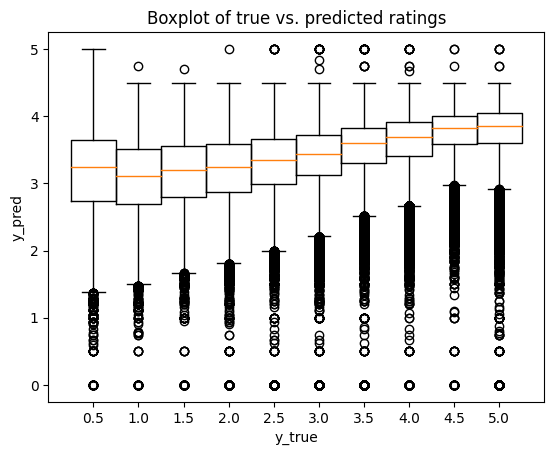

In [54]:
make_boxplots(y_true, y_pred)

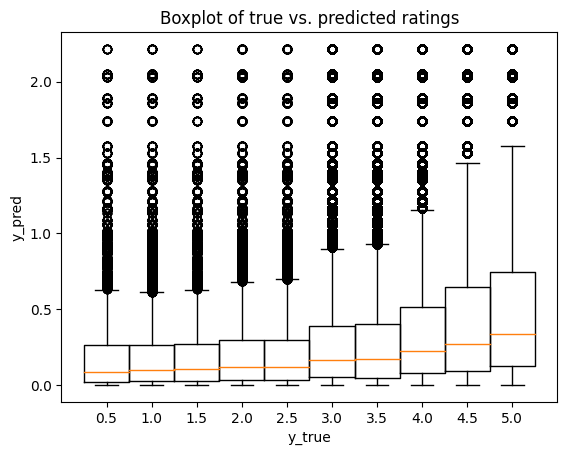

In [55]:
make_boxplots(y_true_zeros_condensed, y_pred_zeros_condensed)